In [1]:
from dolfin import *
from IPython.display import HTML
import matplotlib.pyplot as plt
import mshr as mh
import time
from math import floor
%matplotlib inline

La ecuación que trabajaremos será la ecuación del calor en medio isotrópico no homogéneo

$$u_t - \kappa(x)A(x)\nabla u = f_e(x)$$

Donde

* $u(x,t)$ es la temperatura

* $f_e(x)$ representa una fuente o fuentes de calor (estufas).

* $\kappa(x) = \dfrac{1}{\rho c_e}$ es la inversa (multiplicativa) del calor específico, multiplicado por la densidad, del medio en $x$. Se asumirá constante por pedazos (los medios que trabajaremos serán aire y paredes principalmente).

* $A(x)$ es la conductividad térmica del medio en $x$. Al asumir un medio isotrópico (cuya conductividad no depende de la dirección) es una matriz diagonal. También la asumimos constante por pedazos (de no serlo, ese término sería $\kappa(x) \sum_{i,j} \partial_{x_i} (A(x)\partial_{x_j}u)$)

Usaremos diferentes condiciones de borde. Podemos asumir, por ejemplo, condiciones de borde de tipo Dirichlet (temperatura exterior constante), condiciones de borde de tipo Neumann (para modelar el hecho de que hay temperatura que sale al exterior), o bien una condición mixta.


En primer lugar, se trabajará el problema simplificado a una habitación. Posteriormente, se extenderá a una casa en 2D.

In [2]:
''' #### EN ESTE Y EL SIG. BLOQUE se resuelve el caso simplificado ####
Los parámetros a definir serán:
la discretización temporal (número de pasos),
la temperatura exterior,
la temperatura y posición de la estufa,
las áreas que son paredes,
el calor específico y conductividad térmica de cada medio (aire, pared)
'''
#Parámetros experimento 1 (habitación cerrada, cuadrada)
T = 1800 # Tiempo final (segundos)
número_pasos = 300
temperatura_exterior = 10.
temperatura_estufa = 600.
x_estufa = 2/7 #posición de la estufa
y_estufa = 5/7
#Booleano que, en C++, evalúa que un punto esté dentro de alguna pared (después probablemente lo haré con clases) 
en_paredes = "(x[0]<=1/7 || x[0]>= 6/7 || x[1]<=1/7 || x[1]>= 6/7)"
#Calores específicos, densidades y conductividades térmicas de ambos medios (pared y aire)
#(Los asumiremos constantes, en realidad cambian con la temperatura y presión: esto será importante en el caso 3D)
cal_esp_p = 0.88
rho_p = 2300 #asumimos pared de concreto
cond_p = 1.63

cal_esp_a = 1.01
rho_a = 1.24
cond_a = 0.02

In [84]:
"""ESTE BLOQUE DEFINE, para el caso general, las clases y funciones necesarias para construir el mallado
y entregar los parámetros del problema"""

class InitError(Exception):
    pass

# Clase madre para las estructuras
class rect:
    def __init__(s,args):
        print(args)
        if len(args)==2: #opción 1: pasarle 2 puntos e.g. rect( [[0,0], [1,3]] )
            s.p1 = args[0]
            s.p2 = args[1]
            s.hor = abs(s.p2[0]-s.p1[0])
            s.ver = abs(s.p2[1]-s.p1[1])
        elif len(args) == 3: #opción 2: pasarle un punto, largo horizontal y largo vertical e.g. rect( [[0,0],1,3] )
            s.p1, s.hor, s.ver = args
            s.p2 = [s.p1[0]+s.hor , s.p1[1]+s.ver]
        else: raise InitError("Rectángulo no correctamente inicializado")

#pared es un rectángulo con ciertas propiedades físicas
class pared(rect):
    def __init__(s,geom, prop = [0.88, 2300, 1.63]): #coords es la info geométrica de la pared; props son las propiedades físicas
        rect.__init__(s,geom)#heredar todos los atributos de rect: p1,p2,hor,ver
        s.cal_esp = prop[0]
        s.rho = prop[1]
        s.cond = prop[2]
        
    def cpp(s, x = 'x[0]', y = 'x[1]'): 
        #Entrega string de la función booleana que evalúa si el punto P está en la pared. El punto P los strings
        #con que se van a representar las coordenadas del punto en la función
        a, b = (str(c) for c in s.p1)
        c, d = (str(c) for c in s.p2)
        b = "(%s >= %s && %s <= %s && %s >= %s && %s <= %s)" % (x,a,x,b,y,c,y,d)
        return b
    
    def cpp_b(s,x = 'x[0]', y = 'x[1]', eps = 0.1):
        #Análogo a pared.cpp() que entrega parametrización de la región eps unidades de longitud a cada lado de cada borde,
        #para refinar la malla
        x1,y1 = (str(c) for c in s.p1)
        x2, y2 = (str(c) for c in s.p2)
        b = "(abs(%s - %s) - %s || abs(%s - %s) - %s || abs(%s - %s) - %s || abs(%s - %s) - %s)" % (x,x1,eps,x,x2,eps,
                                                                                                    y,y1,eps,y,y2,eps)
        return b
    
class pared_ext(pared):
    def __init__(s,geom, prop, direccion):
        pared__init__(s,geom,prop)
        s.dir = dirección #puede ser "N", "O", "S", "E" e indica la dirección en la que es exterior (para el borde)
        
    def cpp_bext(s,x = 'x[0]', y = 'x[1]',eps = "DOLFIN_EPS"):
        #String de la función booleana que evalúa si se está en el borde de la casa.
        x1, y1 = (str(c) for c in s.p1)
        x2, y2 = (str(c) for c in s.p2)
        if s.dir == "N":
            b = "(%s >= %s && %s <= %s && %s > %s - %s)" % (x,x1,x,x2, y,y2,eps)
        elif s.dir == "O":
            b = "(%s >= %s && %s <= %s && %s < %s + %s)" % (y,y1,y,y2, x,x1,eps)
        elif s.dir == "S":
            b = "(%s >= %s && %s <= %s && %s < %s + %s)" % (x,x1,x,x2, y,y1,eps)
        elif s.dir == "E":
            b = "(%s >= %s && %s <= %s && %s > %s - %s)" % (y,y1,y,y2, x,x2,eps)
        else: raise InitError("Dirección de la pared debe ser una de las cuatro: N, O, S, E")
        return b
    def cpp_b(s,x = 'x[0]', y = 'x[1]', eps = 0.1): #modifica cpp_b para que entrege solo la región opuesta a la de afuera
        x1, y1 = (str(c) for c in s.p1) #A esta altura me doy cuenta que podía evitar el str() usando %f después, pero eso podría
        x2, y2 = (str(c) for c in s.p2) #                                                      traer bugs si se ingresan enteros
        if s.dir =="N":
            b = "(%s >= %s && %s <= %s && abs(%s - %s) <= %s)" % (x,x1, x,x2,  y,y1,eps)
        elif s.dir == "O":
            b = "(%s >= %s && %s <= %s && abs(%s - %s) <= %s)" % (y,y1, y,y2,  x,x1,eps)
        elif s.dir == "S":
            b = "(%s >= %s && %s <= %s && abs(%s - %s) <= %s)" % (x,x1, x,x2,  y,y2,eps)
        elif s.dir == "E":
            b = "(%s >= %s && %s <= %s && abs(%s - %s) <= %s)" % (y,y1, y,y2,  y,y2,eps)
        else: raise InitError("Dirección de la pared debe ser una de las cuatro: N, O, S, E")
        return b
    
class estufa:
    def __init__(s, P, t= 600):
        s.p = p #coordenadas de la estufa
        s.t = t #temperatura de la estufa
    
class Casa(pared): #Construye el dominio del problema a partir de los bloques dados
    def __init__(s, paredes_externas, paredes_internas, estufas):
        #Observación! las paredes pueden tener distintos atributos físicos, por lo que el orden de las paredes importará
        #(ya que se pueden sobreponer entre sí). Una solución sólida sería programar la diferencia de rectángulos, ya que éstos
        #forman una 
        
        


[[0, 0], [1, 7]]


'(x >= 0 || x <= 0 || y >= 1 || y <= 7)'

In [85]:
"""sdfvsdfvs %s sdfvsdfv
svdfsd %s 
sadvsdf""" % ("1", "2")

'sdfvsdfvs 1 sdfvsdfv\nsvdfsd 2 \nsadvsdf'

TypeError: decoding to str: need a bytes-like object, int found

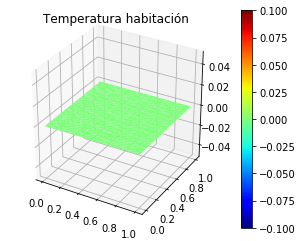

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


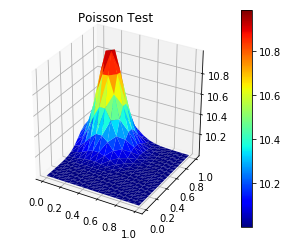

Tiempo: 6.00, solución guardada con norma L2 10.113231


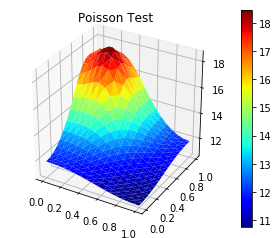

Tiempo: 186.00, solución guardada con norma L2 13.637447


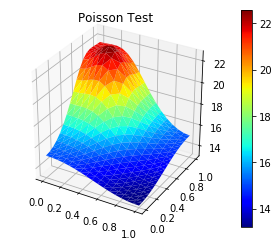

Tiempo: 366.00, solución guardada con norma L2 17.003083


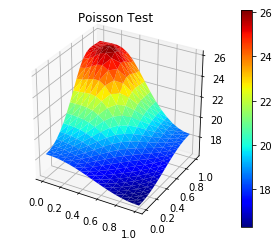

Tiempo: 546.00, solución guardada con norma L2 20.316443


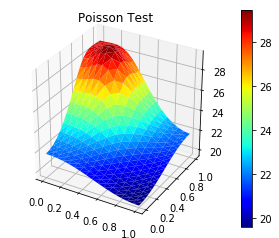

Tiempo: 726.00, solución guardada con norma L2 23.625611


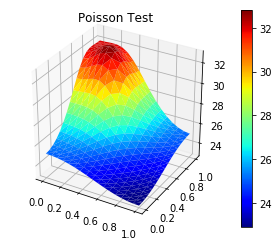

Tiempo: 906.00, solución guardada con norma L2 26.938741


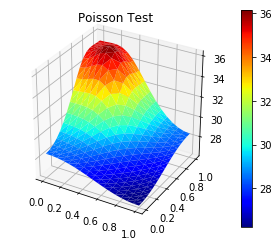

Tiempo: 1086.00, solución guardada con norma L2 30.256032


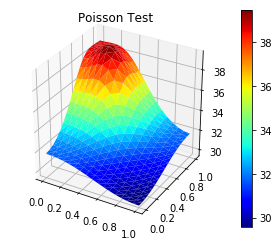

Tiempo: 1266.00, solución guardada con norma L2 33.576587


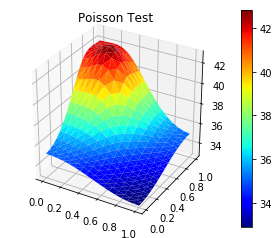

Tiempo: 1446.00, solución guardada con norma L2 36.899599


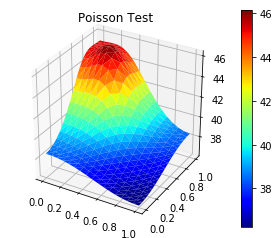

Tiempo: 1626.00, solución guardada con norma L2 40.224476
Iteración terminada


In [5]:
#Esto no se toca, salvo para debuggear

# Paso de tiempo
Δt = T / número_pasos

# Crear malla y si es necesario, refinar cerca de la estufa
malla = UnitSquareMesh(16,16)
"""malla = UnitSquareMesh(16,16)
subdom = MeshFunction("bool", malla, 2)
subdom.set_all(False)
circulito = 'pow(x[0] - x_0, 2) + pow(x[1] - x_1, 2) <= pow(r, 2)'
subdomain = CompiledSubDomain(circulito, x_0 = x_estufa,x_1 = y_estufa,r = 0.1)
subdomain.mark(subdom, True)
malla = refine(malla, subdom)"""
# Espacio de funciones a considerar
V = FunctionSpace(malla,'Lagrange', 1)

##Funciones
#algunas variables auxiliares
eps = 0.02
en_aire = "!"+en_paredes  #el aire es el espacio que queda

#Función de la fuente
f = Expression("t_e*exp(-(pow(x[0] - x_e, 2) + pow(x[1] - y_e, 2))/reg)", degree = 1,
               x_e = x_estufa, y_e = y_estufa,
               t_e = temperatura_estufa, reg = eps)
#Función de conductividad térmica
K = Expression("k_pared*"+en_paredes+" + k_aire*"+en_aire, degree=1,
              k_pared = cond_p, k_aire  = cond_a)
#Función de calor específico (junto con la densidad)
ρC = Expression("d_pared*C_pared*"+en_paredes+" + d_aire*C_aire*"+en_aire, degree = 1,
                d_pared = rho_p, C_pared = cal_esp_p,
                d_aire  = rho_a,  C_aire = cal_esp_a)
# Condiciones de borde
#Borde Dirichlet
cpp_borde = "(x[0] < DOLFIN_EPS || x[0] > 1. - DOLFIN_EPS || x[1] < DOLFIN_EPS || x[1] > 1. - DOLFIN_EPS ) && on_boundary"
cpp_borde = "x[0]<-1"
bc = DirichletBC(V, Constant(temperatura_exterior), cpp_borde)

#Borde Neumann (consideraremos que no varía en los bordes: más adelante, variará según la temperatura de afuera)
g = Expression("0.", degree = 1)

#Funciones para la formulación variacional
u, v = TrialFunction(V), TestFunction(V)
u_n = Function(V)

##Formulación variacional y sistema lineal
F = u*v*dx + Δt*inner(grad(u), grad(v))*(K/ρC)*dx - (u_n + Δt*f/ρC)*v*dx - Δt*g*v*ds
a, L = lhs(F), rhs(F)

# Preparación para guardar la solución
archivo_sol = File('Resultados/calor.pvd')
sols = []

# Iteración principal
u = Function(V)
u_n.assign(Expression(str(temperatura_exterior), degree = 1))
fig = plt.figure()
p = plot(u, title="Temperatura habitación", mode="warp")
fig.colorbar(p)
plt.show()
t = 0
for n in range(número_pasos):
    # Update-time
    t += Δt
    # Solve linear system
    solve(a == L, u, bc)
    
    # Save results
    archivo_sol << (u, t)
    
    if n % floor(número_pasos/10) == 0:
        fig = plt.figure()
        p = plot(u, title="Poisson Test", mode="warp")
        fig.colorbar(p)
        plt.show()
        print("Tiempo: {:.2f}, solución guardada con norma L2 {:4f}".format(t,norm(u, "L2")))
    # Update solution at time n and save to list for plotting
    u_n.assign(u)
    sols.append(u.copy(deepcopy=True))

print("Iteración terminada")